# FairPair Demo

In [1]:
import numpy as np
import networkx as nx
import matplotlib as plt

from fairpair import *

## Create graph with labeled nodes

In [2]:
# Initialize the graph with nodes labeled "privileged" or "unprivileged"
G = FairPairGraph()
G.generate_groups(400, 200)

for i in range(198, 203):
    print(G.nodes(data=True)[i])

{'unpriv': False}
{'unpriv': False}
{'unpriv': True}
{'unpriv': True}
{'unpriv': True}


In [3]:
# Add randomization to the group label attribution
G = FairPairGraph()
G.add_nodes_from(np.arange(500))
G.label_unpriv(200, random=True)

for i in range(5):
    print(G.nodes(data=True)[i])

{'unpriv': True}
{'unpriv': False}
{'unpriv': True}
{'unpriv': True}
{'unpriv': True}


In [4]:
# Access the unprivileged group's subgraph (read-only)
G.unpriv

In [5]:
# Access the privileged nodes
G.priv_nodes[:20]

[1, 6, 9, 10, 11, 12, 13, 14, 18, 19, 20, 23, 24, 26, 27, 28, 29, 31, 32, 34]

## Assign scores per group

In [6]:
# Assign scores to the privileged and unprivileged group respectively
G.group_assign_scores(nodes=G.priv_nodes, distr=Distributions.normal_distr)
G.group_assign_scores(nodes=G.unpriv_nodes, distr=Distributions.normal_distr, loc=-0.4) # give a disadvantage to the unprivileged group
G.nodes(data=True)[11]

{'unpriv': False, 'score': 0.27023096623642523}

In [7]:
# Alternatively, we can keep book of skill scores and perceived scores separately
G.assign_skills() # assigns skills from a standard normal distribution by default
G.assign_bias(nodes=G.unpriv_nodes, loc=-0.5, scale=0.5) # custom parameters for the bias distribution
G.nodes(data=True)[11]

{'unpriv': False, 'score': 1.6121937633001542, 'skill': 1.6121937633001542}

## Compare Pairs

In [8]:
# Compare pairs using the BTL-model
print('perceived score of node 1:', G.nodes[1]['score'])
print('perceived score of node 5:', G.nodes[5]['score'])
print('edges in G before the comparison:\n ', G.edges(data=True))
G.compare_pair_exp(1, 5, k=30)  # use the exponential version of the BTL model (i.e., the softmax function)
print('edges in G after the comparison:\n ', G.edges(data=True))
G.compare_pair_exp(1, 5, k=30)  # use the exponential version of the BTL model (i.e., the softmax function)
print('edges in G after some more comparisons:\n ', G.edges(data=True))

perceived score of node 1: -0.28374654841971775
perceived score of node 5: -0.9140838909084712
edges in G before the comparison:
  []
edges in G after the comparison:
  [(1, 5, {'wins': 10, 'weight': 0.3333333333333333}), (5, 1, {'wins': 20, 'weight': 0.6666666666666667})]
edges in G after some more comparisons:
  [(1, 5, {'wins': 20, 'weight': 0.3333333333333333}), (5, 1, {'wins': 40, 'weight': 0.6666666666666667})]


## Random Sampling
For a comparison of sampling techniques, see also [sampling.ipynb](./sampling.ipynb).

In [9]:
# Generate a new Graph to test random sampling
G = FairPairGraph()
G.generate_groups(20, 5)
G.assign_skills()
G.assign_bias(nodes=G.unpriv_nodes, loc=-0.5, scale=0.5)

In [10]:
# Initialize random sampling
sampling = RandomSampling(G)
# Apply random sampling
sampling.apply(iter = 30)
print('unprivileged group success rate:', round(np.mean([rate for node, rate in G.unpriv.success_rates]), 2))
print('privileged group rate:', round(np.mean([rate for node, rate in G.priv.success_rates]), 2))

unprivileged group success rate: 0.56
privileged group rate: 0.5


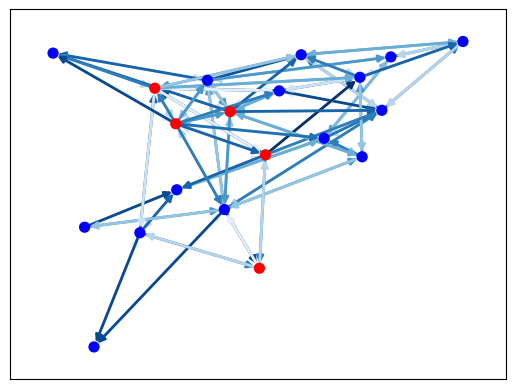

In [11]:
# Visualize the randomly sampled comparison graph
pos=nx.drawing.layout.spring_layout(G)
colors = ['red' if node[1]['unpriv'] else 'blue' for node in G.nodes(data=True)]
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.drawing.nx_pylab.draw_networkx(G, pos, node_color=colors, with_labels=False, node_size=50, edge_color=weights, width=2, edge_cmap=plt.cm.Blues)

## Ranking Recovery

In [12]:
# Initialize ranking recovery
ranker = RankRecovery(G)
# Apply a ranking recovery algorithm
ranking,_ = ranker.apply() # by default, apply the RankCentrality recovery method
ranker._print_with_score(ranking) # print the ranked nodes, sorted by rank score

,node,perceived score,rank score
0,4,1.241165,0.246915
1,18,0.085768,0.244437
2,11,0.453292,0.242544
3,1,0.162861,0.242040
4,2,0.195018,0.239467
5,5,0.573171,0.238879
6,7,0.760203,0.238742
7,17,0.330377,0.237891
8,14,-0.145957,0.229857
9,9,0.250871,0.227637


In [13]:
# Evaluate the recovered ranking
print('Overall error:', weighted_tau(G, ranking))
print('Privileged group\'s error:', weighted_tau(G, ranking, G.priv))
print('Unprivileged group\'s error:', weighted_tau(G, ranking, G.unpriv))
print('Privileged group\'s exposure:', exposure(G, ranking, G.priv))
print('Unprivileged group\'s exposure:', exposure(G, ranking, G.unpriv))

Overall error: 0.259760877265157
Privileged group's error: 0.25908459590113264
Unprivileged group's error: 0.35145308504387224
Privileged group's exposure: 0.35898835264730755
Unprivileged group's exposure: 0.3310886184427797
